In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [4]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

3.0%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
train_data.data.size()

torch.Size([60000, 28, 28])

In [10]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [12]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
    
    'test': DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
}

In [13]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ff09a409030>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ff09a408400>}

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        return F.softmax(x)

In [19]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx + len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]): .0f}%)]\t{loss.item():.6f}')

def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n)')


In [20]:
for epoch in range(1, 11):
    train(epoch)
    test()

/tmp/ipykernel_3940/1760565177.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [100/60000 ( 0%)]	3.911675
Train Epoch: 1 [120/60000 ( 3%)]	3.823142
Train Epoch: 1 [140/60000 ( 7%)]	3.794982
Train Epoch: 1 [160/60000 ( 10%)]	3.679135
Train Epoch: 1 [180/60000 ( 13%)]	3.708125
Train Epoch: 1 [200/60000 ( 17%)]	3.702607
Train Epoch: 1 [220/60000 ( 20%)]	3.655591
Train Epoch: 1 [240/60000 ( 23%)]	3.571220
Train Epoch: 1 [260/60000 ( 27%)]	3.585598
Train Epoch: 1 [280/60000 ( 30%)]	3.549232
Train Epoch: 1 [300/60000 ( 33%)]	3.587404
Train Epoch: 1 [320/60000 ( 37%)]	3.614956
Train Epoch: 1 [340/60000 ( 40%)]	3.549458
Train Epoch: 1 [360/60000 ( 43%)]	3.517957
Train Epoch: 1 [380/60000 ( 47%)]	3.603573
Train Epoch: 1 [400/60000 ( 50%)]	3.516009
Train Epoch: 1 [420/60000 ( 53%)]	3.590948
Train Epoch: 1 [440/60000 ( 57%)]	3.585319
Train Epoch: 1 [460/60000 ( 60%)]	3.549927
Train Epoch: 1 [480/60000 ( 63%)]	3.607051
Train Epoch: 1 [500/60000 ( 67%)]	3.520535
Train Epoch: 1 [520/60000 ( 70%)]	3.492848
Train Epoch: 1 [540/60000 ( 73%)]	3.555050
Train Epoch: 1

In [21]:
device

device(type='cpu')

/tmp/ipykernel_3940/1760565177.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediction: 2


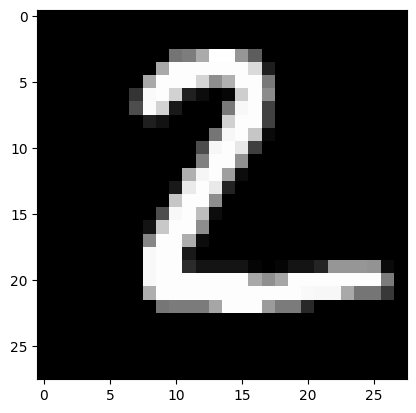

In [23]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[1]

data = data.unsqueeze(0).to(device)

output = model(data)

predition = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {predition}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()